# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"

/*import libtorch header file*/
#include <torch/torch.h>

---

***此处仅为随堂笔记，详情请参考[公开课教程](http://courses.d2l.ai/zh-v2/)***

- [2021.03.27 13:05]  
    首次直播：北京时间 2021.03.27，13:00 pm  
    机器之心首播，B站录播地址随后附上；   
    ***[公开课讲义1](http://courses.d2l.ai/zh-v2/assets/pdfs/part-0_8.pdf)***    
    ***[公开课讲义2](http://courses.d2l.ai/zh-v2/assets/pdfs/part-0_9.pdf)***

# 1.线性回归介绍

从美国买房谈起；
1.看房;
2.出价；


- 从一个简化模型讲起：  
假设1：影响房价的因素有卧室个数，卫生间个数和居住面积，记为$x_1$，$x_2$，$x_3$；  
假设2：成交价是影响因素的加权和：$y = w_1*x_1 + w_2*x_2 + w_3*x_3 + b$


给定n维输入 $\large{\textbf{x}} = {[x_1, x_2, ..., x_n]}^T$；  
针对n维权重和一个标量偏差： $\large{\textbf{w}} = {[w_1, w_2, ..., w_n]^T,   b}$

会得到一个输出$y$：  
$y = w_1*x_1 + w_2*x_2 +\ ...\ + w_n*x_n + b$    

用向量表示就是  
$y = \large{\textbf{<w,x>}} + b$


从上面公式可以得出，已知$\large{\textbf{w}}$和$b$，根据$\large{\textbf{x}}$，可以很容易估计出房屋价格$y$;

---
因为有了$\large{\textbf{w}}$和$\textbf{b}$，我们就可以很容易的去预测房价了。

因此现在的首要问题是，已知房屋价格$\hat{y}$和房价影响因素$\large{\textbf{x}}$，如何去求解$\large{\textbf{w}}$和$\textbf{b}$?

---

要求得最优$\large{\textbf{w}}$和$\textbf{b}$，则需要定义一个损失函数，使得我们预测的房价和真实房价的差最小（不一定是0）；  

定义损失函数$\mathscr{l(y, \hat{y})} = {|\hat{y} - y|^2}$  
这叫平方损失函数(且是凸函数，因此可以求得最优解)；(注：下面临时截图相关公式，后续有空再用LaTeX重写)

![解析解](./images/01.png)

# 2.优化算法

梯度下降：
$w_t = w_{t-1} - \eta * \frac{\partial{\mathscr{l}}}{\partial{w_{t-1}}}$  
即沿着梯度的反方向下降，更新$\large{w}$，使得损失值，t代表迭代轮次，$\eta$就是学习率。

小批量随机梯度下降；

# 3.线性回归从零开始实现

首先构造一个数据集，它是一个线性模型，同时，为了更接近实际情况，还需要加入随机噪声$\epsilon$：  
$y = \textbf{X*w} + b + \epsilon$  
此处我们假设$\text{w} = [2.0, -3.4]^T,  b = 4.2$

In [2]:
typedef std::tuple<torch::Tensor, torch::Tensor> sample_set;

In [3]:
sample_set synthetic_data(torch::Tensor w, torch::Tensor b, int num_example)
{
    torch::Tensor X = torch::normal(0.0, 1.0, {num_example, w.size(0)}); 
    torch::Tensor y = X.matmul(w) + b;
    y = y + torch::normal(0.0, 0.1, y.sizes());
    
    return std::make_tuple(X, y);
}

In [4]:
float coe[] = {2.0, 3.4};
float bias[] = {4.2};

/** calling 'from_blob(...)' may cause compile error with my
 *  xeus-clilng enviroment, so here I changed it with another
 *  way; but maybe you can try it in your pc;
 */
// torch::Tensor true_w = torch::from_blob(coe, {2, 1});
// torch::Tensor true_b = torch::from_blob(bias, {1});

torch::Tensor true_w = torch::tensor(at::ArrayRef<float>({2.0, 3.4}));
torch::Tensor true_b = torch::tensor(at::ArrayRef<float>({4.2}));
sample_set data = synthetic_data(true_w, true_b, 10);

printT(std::get<0>(data));

std::get<0>(data) = 
-0.0602 -1.0727
 1.2110  1.1665
 0.6454 -2.6821
 0.8474 -2.0747
 0.0996 -0.0248
 0.6209  2.4431
 0.3935  0.8256
-1.4985  0.6005
 0.1749  1.4557
 0.9010  2.4344
[ CPUFloatType{10,2} ]
<<--->>



In [5]:
#define DSIZE 1000
sample_set tdata = synthetic_data(true_w, true_b, DSIZE);

std::vector<float> x, y, z;
torch::Tensor t = std::get<0>(tdata);
torch::Tensor r = std::get<1>(tdata);
for (int i = 0; i < DSIZE; i++) {
  x.push_back(t[i][0].item<float>());
  y.push_back(t[i][1].item<float>());
  z.push_back(r[i].item<float>());
}

In [6]:
plt::plot(x, z, "og");
plt::show();
// plt::save("./test2.png");
// auto img1 = im::image("./test2.png");
// img1

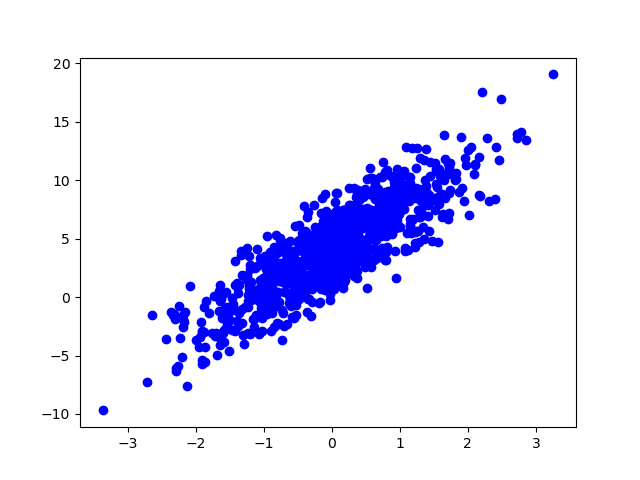

In [7]:
plt::plot(y, z, "ob");
// plt::show();
plt::save("./test3.png");
auto img2 = im::image("./test3.png");
img2

构建一个人造数据集，随机从里面采样一定量的数据用于训练

In [8]:
/* st_sample stands for a piece of training data
 * 1st tensor is data, it can be a image mat, a 1-dim vector;
 * 2nd tensor is label, it is a 1x1 tensor;
 */
typedef std::tuple<torch::Tensor, torch::Tensor> st_sample;
typedef std::vector<sample_set> st_dataset;

#define BATCH_SIZE     4
#define TOTAL_SAMPLE   20


float w1 = 2.0;
float w2 = 3.4;
float b  = 4.2;

torch::Tensor true_w = torch::tensor(at::ArrayRef<float>({w1, w2}));
torch::Tensor true_b = torch::tensor(at::ArrayRef<float>({b}));
sample_set raw_data = synthetic_data(true_w, true_b, TOTAL_SAMPLE);

st_dataset train_;

torch::Tensor X_ = std::get<0>(raw_data);
torch::Tensor y_ = std::get<1>(raw_data);
for (int i = 0; i < TOTAL_SAMPLE; i++) {    
    torch::Tensor t1 = X_.slice(0, i, i+1);
    torch::Tensor t2 = y_.slice(0, i, i+1);
    
    train_.push_back(std::make_tuple(t1, t2));
}

下面利用torch::data::Dataset来构建一个自己的数据集，且借助其接口来随机选取batch data；

In [9]:
class MyDataset : public torch::data::Dataset<MyDataset>
{
    private:
        torch::Tensor states_, labels_;

    public:
        explicit MyDataset(torch::Tensor states, torch::Tensor labels) 
            : states_(states),
              labels_(labels) {   };

        torch::data::Example<> get(size_t index) override {
            return {states_[index], labels_[index]};
        };

        torch::optional<size_t> size() const override {
            return states_.size(0);
        };
};

In [10]:
torch::Tensor t = std::get<0>(raw_data);
printT(t);

auto data_set = MyDataset(std::get<0>(raw_data), std::get<1>(raw_data)).map(torch::data::transforms::Stack<>());

/*SequentialSampler是顺序采样， 还可以使用随机采样*/
auto data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
    std::move(data_set), 
    BATCH_SIZE);

/** data_loader前要加*号，否则报错(http://ghostblog.lyq.me/pytorch-cpp/) */
for (auto& batch : *data_loader) {
    auto data = batch.data;
    auto labels = batch.target;
    // do your usual stuff
    printT(data);
}

t = 
 0.6405 -1.1307
-0.0969  0.0417
-1.0642 -0.2685
-3.2790  0.0311
-0.7134  1.2320
-0.8513  0.1578
 1.3722  1.2081
-0.8287 -0.6096
 0.8049  2.1723
-1.8757  2.2468
-0.3690  0.8385
-0.6831  0.1598
-1.1854 -0.5343
-0.8181 -1.6622
 0.2306 -0.8093
-0.3259 -0.0908
-0.3837 -2.0190
-0.7970  2.2121
 1.4168 -1.4385
-0.9955 -0.1106
[ CPUFloatType{20,2} ]
<<--->>

data = 
-0.3837 -2.0190
 1.4168 -1.4385
-0.3259 -0.0908
-0.6831  0.1598
[ CPUFloatType{4,2} ]
<<--->>

data = 
 1.3722  1.2081
-0.8181 -1.6622
 0.2306 -0.8093
-0.8287 -0.6096
[ CPUFloatType{4,2} ]
<<--->>

data = 
-0.0969  0.0417
-0.7970  2.2121
 0.8049  2.1723
-1.8757  2.2468
[ CPUFloatType{4,2} ]
<<--->>

data = 
 0.6405 -1.1307
-3.2790  0.0311
-0.3690  0.8385
-1.0642 -0.2685
[ CPUFloatType{4,2} ]
<<--->>

data = 
-1.1854 -0.5343
-0.8513  0.1578
-0.7134  1.2320
-0.9955 -0.1106
[ CPUFloatType{4,2} ]
<<--->>



下面是另一种构造dataset的方式，跟上面一样，没有区别，只是成员变量的类型变了：

```
class TestDataset : public torch::data::Dataset<TestDataset>
{
  private:
    //std::list<std::tuple<torch::Tensor/*image*/, torch::Tensor/*label*/>> 
    st_dataset dataset_;

  public:
    //file_path 是数据集描述文件，里面存放着图片以及对应label文件的路径
    explicit TestDataset(st_dataset dataset)
    : dataset_(dataset) {  };

    torch::data::Example<> get(size_t index) override {
      return {std::get<0>(dataset_[index]), std::get<1>(dataset_[index])};
    }
    
    // Override the size method to infer the size of the data set.
    torch::optional<size_t> size() const override {
        return dataset_.size();
    };
}

auto dataset = TestDataset(train_).map(torch::data::transforms::Stack<>());
int batch_size = 4;

// Generate a data loader.
auto data_loader = torch::data::make_data_loader<torch::data::samplers::SequentialSampler>(
    std::move(dataset), 
    batch_size);

/** data_loader前要加*号，否则报错(http://ghostblog.lyq.me/pytorch-cpp/) */
for (auto& batch : *data_loader) {
    auto data = batch.data;
    auto labels = batch.target;
    // do your usual stuff
}
```

准备线性模型、损失函数以及优化算法，并准备训练

In [17]:
torch::Tensor w = torch::normal(0.0, 0.01, {2,1}, c10::nullopt, torch::requires_grad(true));
torch::Tensor b = torch::zeros({1}, torch::requires_grad(true));

In [22]:
torch::Tensor linreg(torch::Tensor X, torch::Tensor w, torch::Tensor b)
{
    return torch::mm(X, w) + b;
}

In [23]:
torch::Tensor squared_loss(torch::Tensor y_hat, torch::Tensor y) 
{
    torch::Tensor delta = y_hat - y.reshape(y_hat.sizes());
    return (torch::mm(delta, delta) / 2.0);
}

In [24]:
void sgd(std::tuple<torch::Tensor, torch::Tensor> params, float lr, int batch_size)
{
    {
        torch::NoGradGuard no_grad;
        torch::Tensor w = std::get<0>(params);
        torch::Tensor b = std::get<1>(params);
        {
            w -= lr * w.grad() / batch_size;
            w.grad().zero_();
            b -= lr * b.grad() / batch_size;
            b.grad().zero_();
        }
    }  
}

In [25]:
float lr = 0.03;
int num_epochs = 3;

for (int i = 0; i < num_epochs; i++) {
    for (auto& batch : *data_loader) {
        auto data = batch.data;
        auto labels = batch.target;
        // do your usual stuff
        torch::Tensor l = squared_loss(linreg(data, w, b), labels);
        l.sum().backward();
        auto params = std::make_tuple(w, b);        
        sgd(params, lr, BATCH_SIZE);
    }
    {
        torch::NoGradGuard no_grad;
        torch::Tensor train_l = squared_loss(linreg(std::get<0>(raw_data), w, b), std::get<1>(raw_data));
        printT(train_l.mean());
    }
}            

Standard Exception: mat1 and mat2 shapes cannot be multiplied (4x1 and 4x1)
Exception raised from addmm_impl_cpu_ at /home/lh/github/libtorch/pytorch/aten/src/ATen/native/LinearAlgebra.cpp:216 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) + 0x69 (0x7f5970a02fd9 in /opt/libtorch/lib/libc10.so)
frame #1: <unknown function> + 0xb734f4 (0x7f595d92d4f4 in /opt/libtorch/lib/libtorch_cpu.so)
frame #2: at::native::addmm_cpu_out(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar, c10::Scalar) + 0x1b6 (0x7f595d92fed6 in /opt/libtorch/lib/libtorch_cpu.so)
frame #3: at::native::mm_cpu(at::Tensor const&, at::Tensor const&) + 0x125 (0x7f595d930fa5 in /opt/libtorch/lib/libtorch_cpu.so)
frame #4: <unknown function> + 0x1090a2d (0x7f595de4aa2d in /opt/libtorch/lib/libtorch_cpu.so)
frame #5: <unknown function> + 0x856e04 (0x7f595d610e04 in /opt/libtorch/lib/libtorch_cpu.so)
frame #6: at::Tensor c10::Dispatcher::callWithDispatchKey<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&)> const&, c10::DispatchKey, at::Tensor const&, at::Tensor const&) const + 0x1ce (0x7f595dff290e in /opt/libtorch/lib/libtorch_cpu.so)
frame #7: at::mm(at::Tensor const&, at::Tensor const&) + 0xb7 (0x7f595ded9007 in /opt/libtorch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x27cedb4 (0x7f595f588db4 in /opt/libtorch/lib/libtorch_cpu.so)
frame #9: <unknown function> + 0x856e04 (0x7f595d610e04 in /opt/libtorch/lib/libtorch_cpu.so)
frame #10: at::Tensor c10::Dispatcher::callWithDispatchKey<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&)> const&, c10::DispatchKey, at::Tensor const&, at::Tensor const&) const + 0x1ce (0x7f595dff290e in /opt/libtorch/lib/libtorch_cpu.so)
frame #11: at::mm(at::Tensor const&, at::Tensor const&) + 0xb7 (0x7f595ded9007 in /opt/libtorch/lib/libtorch_cpu.so)
frame #12: [0x7f58a730e1f5]
frame #13: [0x7f58a72ff1ef]
frame #14: cling::IncrementalExecutor::executeWrapper(llvm::StringRef, cling::Value*) const + 0x348 (0x7f597c388f88 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus-cling.so.0)
frame #15: cling::Interpreter::RunFunction(clang::FunctionDecl const*, cling::Value*) + 0x97 (0x7f597c2ea0d7 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus-cling.so.0)
frame #16: cling::Interpreter::EvaluateInternal(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, cling::CompilationOptions, cling::Value*, cling::Transaction**, unsigned long) + 0x1d6 (0x7f597c2eba26 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus-cling.so.0)
frame #17: cling::Interpreter::process(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, cling::Value*, cling::Transaction**, bool) + 0x15b (0x7f597c2ebd3b in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus-cling.so.0)
frame #18: xcpp::interpreter::execute_request_impl(int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, bool, bool, nlohmann::basic_json<std::map, std::vector, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, bool, long, unsigned long, double, std::allocator, nlohmann::adl_serializer, std::vector<unsigned char, std::allocator<unsigned char> > >, bool) + 0x2d4 (0x7f597c291904 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus-cling.so.0)
frame #19: xeus::xinterpreter::execute_request(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, bool, bool, nlohmann::basic_json<std::map, std::vector, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, bool, long, unsigned long, double, std::allocator, nlohmann::adl_serializer, std::vector<unsigned char, std::allocator<unsigned char> > >, bool) + 0x135 (0x7f59807f8b25 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #20: xeus::xkernel_core::execute_request(xeus::xmessage const&, xeus::channel) + 0x4df (0x7f5980809dcf in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #21: xeus::xkernel_core::dispatch(zmq::multipart_t&, xeus::channel) + 0x1e6 (0x7f598080b586 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #22: xeus::xserver_zmq::poll(long) + 0x3e6 (0x7f59808211e6 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #23: xeus::xserver_zmq::start_impl(zmq::multipart_t&) + 0x50 (0x7f5980821640 in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #24: xeus::xkernel::start() + 0x4c (0x7f59807faaac in /home/lh/anaconda3/envs/cpp/bin/../lib/libxeus.so.1)
frame #25: main + 0x234 (0x55dd93239674 in /home/lh/anaconda3/envs/cpp/bin/xcpp)
frame #26: __libc_start_main + 0xf0 (0x7f597b35a840 in /lib/x86_64-linux-gnu/libc.so.6)
frame #27: <unknown function> + 0xdea5 (0x55dd93239ea5 in /home/lh/anaconda3/envs/cpp/bin/xcpp)
